## Features reduction

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

np.random.seed = 7

#df = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_train.xls")

df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#Drop 'protected' features
drop_cols = ['prop', 'other_prop', 'other_resp']
df = df[[col for col in df.columns if col not in drop_cols]]

## comment/uncomment for shuffling
df = df.sample(frac=1.0)
df_train = df.head(df.shape[0] - 100)
df_train.to_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_train.xls")
df_test = df.tail(100)
df_test.to_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test.xls")


df_full = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
df_min = df_full.min()
df_max = df_full.max()


df.head()


,time_spent_risk,cells,selfish,time_spent_prop,count_effort,Honesty_Humility,Extraversion,Agreeableness,min_offer
95,22000,24,50,53000,15,4.0,3.6,4.0,100
166,90000,40,60,64000,11,4.0,4.1,4.1,60
52,92000,40,45,47000,1,3.6,3.8,3.6,95
78,31000,31,40,23000,20,3.5,4.3,3.5,50
19,9000,9,10,16000,20,2.8,3.3,2.8,15


## Determine significant features

**Feature importance permutation**

In [2]:
from utils.preprocessing import df_to_xy, df_to_xydf
from models import AcceptanceModel
from utils.benchmark import process_model, process_benchmark_cv
from mlxtend.evaluate import feature_importance_permutation

Using TensorFlow backend.


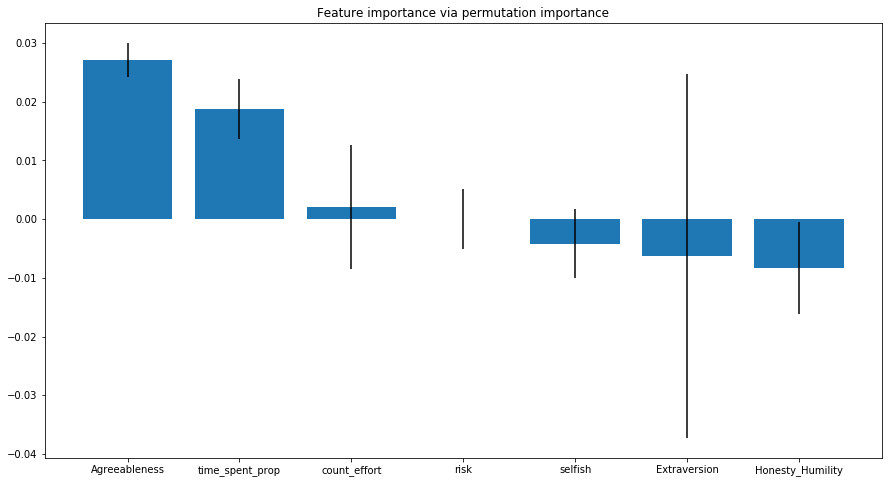

In [17]:
from utils.preprocessing import df_to_xy, df_to_xydf

NB_REPETITIONS = 5

imp_vals = None
imp_all = None
for _ in range(NB_REPETITIONS):
    df_x, df_y = df_to_xydf(df_train.sample(frac=1.0), fuse_risk=True)
    model = AcceptanceModel()
    split = int(0.6 * df_x.shape[0])
    model.fit(df_x.values[:split], df_y.values.ravel()[:split])

    step_imp_vals, step_imp_all = feature_importance_permutation(
        predict_method=model.predict, 
        X=df_x.values[split:],
        y=df_y.values.ravel()[split:],
        metric='accuracy',
        num_rounds=3,
        seed=None)
    if imp_vals is None:
        imp_vals = step_imp_vals
        imp_all = step_imp_all
    else:
        imp_vals += step_imp_vals
        imp_all += step_imp_all


imp_all /= NB_REPETITIONS
imp_vals /= NB_REPETITIONS
std = np.std(imp_all, axis=1)
indices = np.argsort(imp_vals)[::-1]


plt.figure(figsize=(15, 8))
plt.title("Feature importance via permutation importance")
plt.bar(df_x.columns[indices], imp_vals[indices],
        yerr=std[indices],)
plt.show()

In [4]:
res = {}
features = list(df) + ['risk']
if 'min_offer' in features:
    features.remove('min_offer')
for col in features:
    df_train = df_train.sample(frac=1.0)
    if col == 'risk':    
        x, y = df_to_xy(df_train, select_columns=[col], fuse_risk=True, df_min=df_min, df_max=df_max)
        col = 'risk*'
    else:
        x, y = df_to_xy(df_train, select_columns=[col], df_min=df_min, df_max=df_max)
    model = AcceptanceModel()
    item_res = process_benchmark_cv(model, X=x, y=y)
    res[col] = item_res.mean()

res_single_df = pd.DataFrame(res).T
res_single_df.sort_values(by=['avg_loss_ratio'], inplace=True)
res_single_df

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
time_spent_prop,24.979167,0.194978,22.800000,393.0,1418.479167,0.076319
risk*,25.079167,0.197483,23.022756,396.0,1390.729167,0.051667
selfish,25.620833,0.201499,23.648397,402.0,1427.479167,0.051667
time_spent_risk,25.687500,0.202260,23.555952,406.0,1417.020833,0.050833
cells,25.900000,0.202861,23.933333,410.0,1452.250000,0.050000
Extraversion,27.533333,0.221755,23.502747,436.0,1633.041667,0.076615
count_effort,29.358333,0.238208,24.483516,464.0,1803.666667,0.092969
Agreeableness,32.716667,0.267850,28.138095,517.0,1970.791667,0.107813
Honesty_Humility,33.812500,0.283899,25.235577,533.0,2251.104167,0.133323


In [5]:
from itertools import combinations


features = list(df_train)
if 'min_offer' in features:
    features.remove('min_offer')

res = {}
for cols in combinations(features, 2):
    df_train = df_train.sample(frac=1.0)
    #index should be a list
    cols = list(cols)
    if cols[0]==cols[1]: continue
    x, y = df_to_xy(df_train, centered=False, select_columns=cols, df_min=df_min, df_max=df_max)
    model = AcceptanceModel()
    item_res = process_benchmark_cv(model, X=x, y=y)
    res[":".join(cols)] = item_res.mean()

res_duo_df = pd.DataFrame(res).T
res_duo_df.sort_values(by=['avg_loss_ratio'], inplace=True)
res_duo_df.head(10)

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
selfish:time_spent_prop,24.762500,0.194128,22.496795,392.0,1371.270833,0.063792
cells:count_effort,25.762500,0.202955,23.800000,408.0,1409.979167,0.054688
selfish:Extraversion,26.166667,0.206062,24.345513,415.0,1437.791667,0.057813
time_spent_prop:Extraversion,26.558333,0.210067,23.382051,421.0,1555.041667,0.057813
selfish:count_effort,27.700000,0.219742,25.860119,440.0,1511.833333,0.050000
time_spent_risk:time_spent_prop,28.000000,0.224804,25.012500,441.0,1597.083333,0.067344
count_effort:Extraversion,28.654167,0.228596,25.417949,452.0,1653.312500,0.065354
count_effort:Honesty_Humility,28.650000,0.229628,25.701190,453.0,1625.625000,0.078500
time_spent_risk:Extraversion,28.941667,0.234220,25.114286,458.0,1698.291667,0.084076
cells:selfish,29.495833,0.238244,25.348214,465.0,1760.979167,0.080410


In [6]:
from itertools import combinations


features = list(df_train)
if 'min_offer' in features:
    features.remove('min_offer')

res = {}
for cols in combinations(features, 3):
    df_train = df_train.sample(frac=1.0)
    #index should be a list
    cols = list(cols)
    if cols[0]==cols[1]: continue
    x, y = df_to_xy(df_train, centered=False, select_columns=cols, df_min=df_min, df_max=df_max)
    model = AcceptanceModel()
    item_res = process_benchmark_cv(model, X=x, y=y, cv=3)
    res[":".join(cols)] = item_res.mean()

res_trio_df = pd.DataFrame(res).T
res_trio_df.sort_values(by=['avg_loss_ratio'], inplace=True)
res_trio_df.head(10)

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
time_spent_risk:time_spent_prop:count_effort,27.965337,0.223410,25.198328,735.000000,1588.425926,0.061781
time_spent_prop:count_effort:Extraversion,28.200380,0.224281,25.213889,741.666667,1636.728395,0.063799
time_spent_risk:time_spent_prop:Extraversion,28.098291,0.224725,25.180653,740.000000,1621.308167,0.073373
cells:time_spent_prop:count_effort,28.231244,0.226207,25.358333,743.333333,1597.685185,0.076960
time_spent_risk:count_effort:Extraversion,28.872270,0.233785,24.986111,761.666667,1678.858025,0.086015
selfish:time_spent_prop:Agreeableness,29.040836,0.233921,26.137821,765.000000,1632.573599,0.095249
selfish:time_spent_prop:count_effort,29.320988,0.234336,26.618841,773.333333,1686.063628,0.059208
selfish:count_effort:Honesty_Humility,29.584520,0.237348,26.813889,778.333333,1675.130579,0.068084
time_spent_risk:selfish:Honesty_Humility,29.539411,0.237463,26.711111,778.333333,1666.642925,0.086911
cells:time_spent_prop:Honesty_Humility,29.472934,0.238123,25.631884,776.666667,1744.491928,0.083711


In [7]:
# from itertools import combinations


# features = list(df)
# if 'min_offer' in features:
#     features.remove('min_offer')

# res = {}
# for cols in combinations(features, 4):
#     #index should be a list
#     cols = list(cols)
#     if cols[0]==cols[1]: continue
#     x, y = df_to_xy(df, centered=False, select_columns=cols, df_min=df_min, df_max=df_max)
#     model = AcceptanceModel()
#     item_res = process_benchmark_cv(model, X=x, y=y)
#     res[":".join(cols)] = item_res.mean()

# res_quad_df = pd.DataFrame(res).T
# res_quad_df.sort_values(by=['avg_loss_ratio'], inplace=True)
# res_quad_df.head(10)

## Train model with top features

In [8]:
top_columns = ['selfish', 'time_spent_prop']
epsilon = 0.01
if res_duo_df.avg_loss_ratio[0] - epsilon < res_trio_df.avg_loss_ratio[0]:
    top_columns = res_duo_df.index[0].split(':')
else:
    top_columns = res_trio_df.index[0].split(':')
# if res_single_df.avg_loss_ratio[0] - epsilon < res_duo_df.avg_loss_ratio[0] and \
#         res_single_df.avg_loss_ratio[0] - epsilon < res_trio_df.avg_loss_ratio[0]:
#     top_columns = [res_single_df.index[0]]
    
x, y = df_to_xy(df_train, centered=False, select_columns=top_columns, min_target=5, max_target=190, df_min=df_min, df_max=df_max)


In [9]:
split = int(x.shape[0] * 0.6)
xTrain, yTrain = x[:split], y[:split]
xTest, yTest = x[split:], y[split:]


In [10]:
model = AcceptanceModel()
model.fit(xTrain, yTrain)

In [11]:
from models.metrics import gain_mean, avg_loss_ratio
yPred = model.predict(xTest)
print("Val Mean gain: ", gain_mean(yTest, yPred))
print("Val AVG loss ratio: ", avg_loss_ratio(yTest, yPred))

Val Mean gain:  84.84375
Val AVG loss ratio:  0.2741675511988011


In [12]:
print("Unique values: ", np.unique(yTest))
print("Unique predicted values: ", np.unique(yPred))

Unique values:  [  5  35  50  75  80  90  95 100 125 150]
Unique predicted values:  [ 80.  95. 100. 105.]


## Generate data for the survey

In [13]:
# Read and sanitize the data
df_train = df.head(df.shape[0] - 100)
#df_test = df.tail(100)
df_test = pd.read_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test.xls")

df_features, df_y = df_to_xydf(df_test, centered=True, select_columns=top_columns, df_min=df_min, df_max=df_max)
predictions = model.predict(df_features.values).astype(int)

df_final = df_test[top_columns].copy()
#RESCALE FEATURES
df_final['ai_offer'] = predictions.ravel()
df_final['min_offer'] = df_y['min_offer']
df_final.head()

,selfish,time_spent_prop,ai_offer,min_offer
119,0,75000,95,75
60,20,39000,100,100
158,20,41000,100,75
98,40,35000,105,60
73,0,44000,100,80


In [14]:
df_final.to_excel("../data/HH_SURVEY1/UG_HH_NEW_continuous_no200_test_PRED.xls", index=False)

In [15]:
df_final['ai_offer'].unique()

array([ 95, 100, 105,  85,  90])

In [16]:
print("Test/ai - mean gain: ", gain_mean(df_final['min_offer'], df_final['ai_offer']))
print("Test/ai - avg loss ratio: ", avg_loss_ratio(df_final['min_offer'], df_final['ai_offer']))

Test/ai - mean gain:  86.3
Test/ai - avg loss ratio:  0.29047080063598185
